## Simulation vs Observational Data of Shallow Cumulus Clouds over the Southern Great Plains on April 4th, 2019

# Import prerequisites

In [1]:
# Lasso Simulation Data

# import dask
from datetime import datetime
import numpy as np
import xarray as xr
import xwrf

import matplotlib.pyplot as plt

# Load Data and View Variables, Dimensions, and Data Details

In [2]:
# Plotting wrfstat variables...

# path_shcu_root = "/gpfs/wolf2/arm/atm124/world-shared/arm-summer-school-2024/lasso_tutorial/ShCu/untar/"  # on cumulus
path_shcu_root = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/ShCu/untar"  # on Jupyter

case_date = datetime(2019, 4, 4)
sim_id = 4

ds_stat = xr.open_dataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfstat_d01_{case_date:%Y-%m-%d_12:00:00}.nc")
ds_stat

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<xarray.Dataset> Size: 72GB
Dimensions:         (Time: 91, bottom_top: 226, bottom_top_stag: 227,
                     south_north: 250, west_east: 250, west_east_stag: 251,
                     south_north_stag: 251)
Coordinates:
    XTIME           (Time) datetime64[ns] 728B ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north,
                                west_east, west_east_stag, south_north_stag
Data variables: (12/179)
    Times           (Time) |S19 2kB ...
    CST_CLDLOW      (Time) float32 364B ...
    CST_CLDTOT      (Time) float32 364B ...
    CST_LWP         (Time) float32 364B ...
    CST_IWP         (Time) float32 364B ...
    CST_PRECW       (Time) float32 364B ...
    ...              ...
    CSV_IWC         (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSV_CLDFRAC     (Time, bottom_top, south_north, west_east) float32 5GB ...
    CSS_LWP         (Time, south_north, west_east) float32 23MB ...
    CSS_IWP         (Time, south_north, west_east) float32 23MB ...
    CSS_CLDTOT      (Time, south_north, west_east) float32 23MB ...
    CSS_CLDLOW      (Time, south_north, west_east) float32 23MB ...
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

# Plot Variables and Modify as Desired

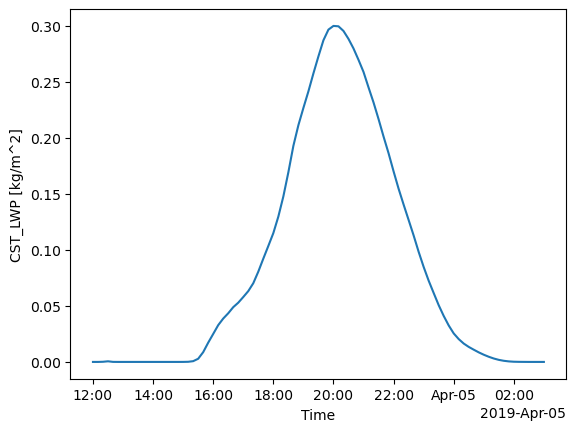

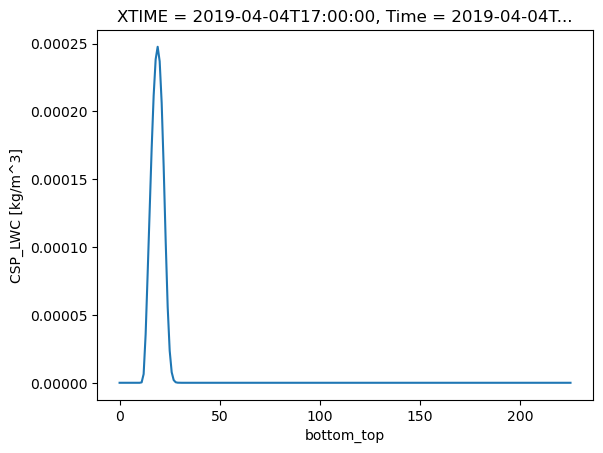

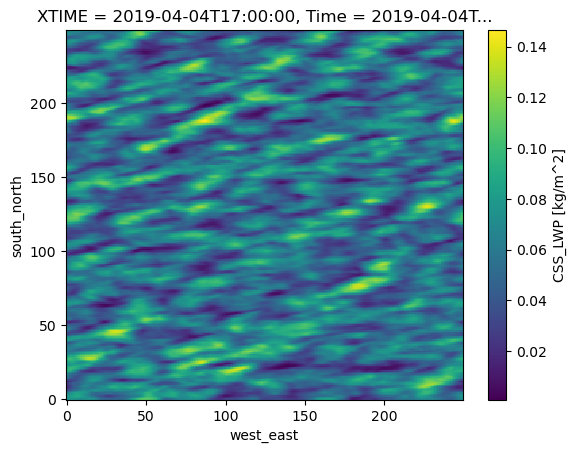

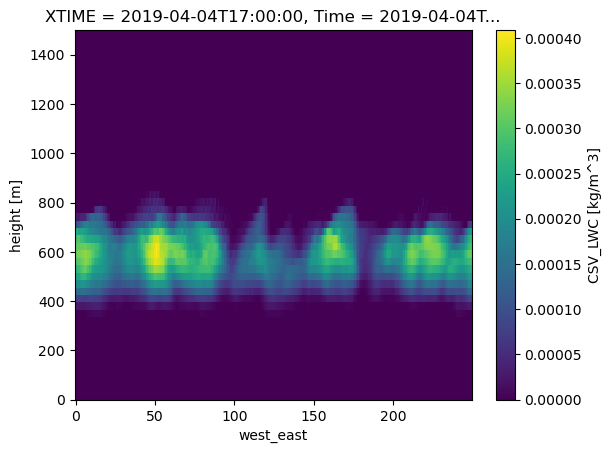

In [3]:
# By default, xarray does not interpret the wrfout/wrfstat time information in a way that attaches 
# it to each variable. Here is at trick to map the time held in XTIME with the Time coordinate 
# associated with each variable.
ds_stat["Time"] = ds_stat["XTIME"]

# Now that we fixed the time coordinate, we can use xarray's plotting features to get time-labeled plots.

hour_to_plot = 17

# Time series:
ds_stat["CST_LWP"].plot()
plt.show()

# Profile at a selected time (plots sideways, though, since we are being lazy):
ds_stat["CSP_LWC"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# X-Y slice for a selected time:
ds_stat["CSS_LWP"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()
plt.show()

# A vertical slice from the volume at a selected time:
# We'll assign the vertical coordinate values for this one and hide the cloud-free upper atmosphere.
plot_data = ds_stat["CSV_LWC"].assign_coords(height=(ds_stat["CSP_Z"]))
plot_data.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00", south_north=1).plot(y="height", ylim=[0, 1500])
plt.show()

# Add lines and modify variables to plot desired figures... In this notebook, we plotted 

# Plot wind speed 

In [5]:
# Open a wrfout time series using a manual approach...

case_date = datetime(2019, 4, 4)
sim_id = 4

# Note the extra details required by open_mfdataset to connect the files together in time.
ds_wrf = xr.open_mfdataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfout_d01_*.nc", 
                           combine="nested", concat_dim="Time")

ds_wrf["Time"] = ds_wrf["XTIME"]  # Fix the time coordinate like we did for the wrfstat file

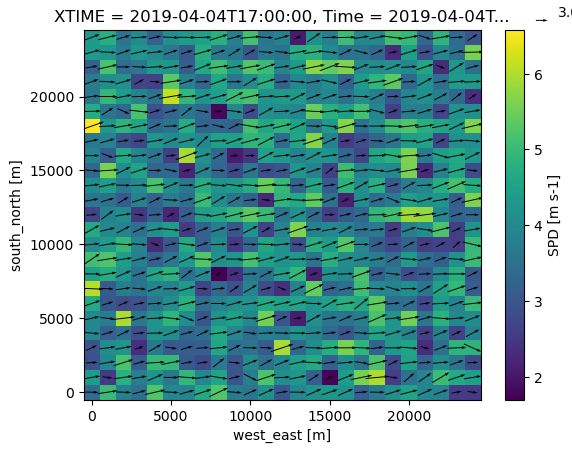

In [6]:
# Plot wind vectors at a selected level to demonstrate how to destagger the wind components to cell-center values with xarray...

plot_level = 12  # index of level to plot
skip_xy = 10  # Sampling interval for the vector thinning

nt, nz, ny, nx = ds_wrf["T"].shape

# We need to:
# 1) destagger to cell centers
# 2) rename the staggered dimension back to the non-staggered name to avoid dimension conflicts
# 3) (re)name the unstaggered wind for convenience
# Then, we are able to put these new DataArrays back into the ds_wrf Dataset.

ds_wrf["UA"] = 0.5*( ds_wrf["U"].isel(west_east_stag=slice(0, nx)) + 
                    ds_wrf["U"].shift(west_east_stag=-1).isel(west_east_stag=slice(0, nx)) ).\
                    rename("UA").rename(west_east_stag="west_east")
ds_wrf["VA"] = 0.5*( ds_wrf["V"].isel(south_north_stag=slice(0, ny)) + 
                    ds_wrf["V"].shift(south_north_stag=-1).isel(south_north_stag=slice(0, ny)) ).\
                    rename("VA").rename(south_north_stag="south_north")
ds_wrf["SPD"] = np.sqrt(ds_wrf["UA"]**2 + ds_wrf["VA"]**2).rename("wind speed").\
                    assign_attrs(units="m s-1", description="wind speed")

# Now, we can proceed to more plotting-specific data manipulation. We need to
# add spatial variables for the idealized domain (since XLAT and XLONG are
# constant in the file). This is needed by the xarray quiver routine.
# Then, thin the grid to reduce the number of arrrows.
ds_wrf["west_east"] = xr.DataArray(data=np.arange(nx)*ds_wrf.attrs["DX"], dims="west_east", name="west_east", attrs={"units": "m"})
ds_wrf["south_north"] = xr.DataArray(data=np.arange(ny)*ds_wrf.attrs["DX"], dims="south_north", name="south_north", attrs={"units": "m"})

ds_wrf_thinned = ds_wrf.\
    isel(west_east=slice(0, nx, skip_xy), south_north=slice(0, ny, skip_xy), bottom_top=plot_level).\
    sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

fig, ax = plt.subplots(ncols=1)
ds_wrf_thinned["SPD"].plot(ax=ax, x="west_east", y="south_north")
ds_wrf_thinned.plot.quiver(ax=ax, x="west_east", y="south_north", u="UA", v="VA",
                           scale=100)
plt.show()

# Compare with Observational Data from ARM

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


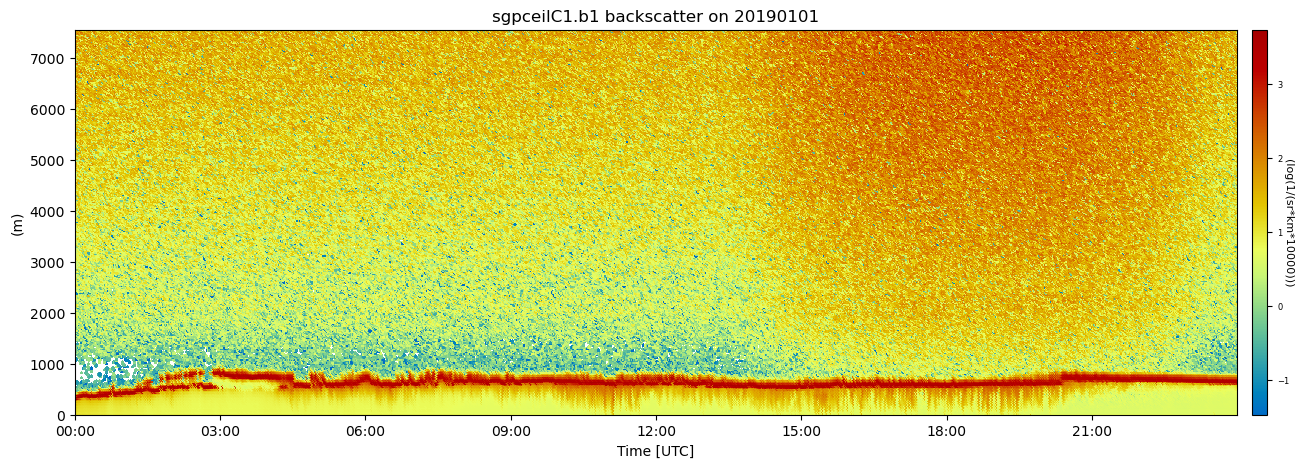

In [7]:
# Compare with ARM Observational Data

import os

from arm_test_data import DATASETS
import matplotlib.pyplot as plt

import act

# Place your username and token here
username = os.getenv('ARM_USERNAME')
token = os.getenv('ARM_PASSWORD')

# If the username and token are not set, use the existing sample file
if username is None or token is None or len(username) == 0 or len(token) == 0:
    filename_ceil = DATASETS.fetch('sgpceilC1.b1.20190101.000000.nc')
    ceil_ds = act.io.arm.read_arm_netcdf(filename_ceil, engine='netcdf4')
else:
    # Example to show how easy it is to download ARM data if a username/token are set
    results = act.discovery.download_arm_data(
        username, token, 'sgpceilC1.b1', '2022-01-14', '2022-01-19'
    )
    ceil_ds = act.io.arm.read_arm_netcdf(results)

# Adjust ceilometer data for plotting
ceil_ds = act.corrections.ceil.correct_ceil(ceil_ds, -9999.0)

# Plot up ceilometer backscatter using HomeyerRainbow CVD friendly colormap
# The same could be done with keyword 'cmap='HomeyerRainbow'
display = act.plotting.TimeSeriesDisplay(ceil_ds, subplot_shape=(1,), figsize=(15, 5))
display.plot('backscatter', subplot_index=(0,), cvd_friendly=True)
plt.show()

In [7]:
# ARM Plotting v2
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Plot Desired Variables

In [8]:
# Set your username and token here!
username = '***'
token = '***'

# Set the datastream and start/enddates
datastream = 'sgpaosmetE13.a1'
startdate = '2019-04-04'
enddate = '2019-04-05'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] sgpaosmetE13.a1.20190404.000000.nc

If you use these data to prepare a publication, please cite:

Kyrouac, J., Springston, S., & Tuftedal, M. Meteorological Measurements
associated with the Aerosol Observing System (AOSMET). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1984920



In [9]:
# Let's read in the data using ACT and check out the data
ds_mpl = act.io.read_arm_netcdf(result)

ds_mpl

<xarray.Dataset> Size: 6MB
Dimensions:              (time: 86399)
Coordinates:
  * time                 (time) datetime64[ns] 691kB 2019-04-04T00:00:00.2200...
Data variables: (12/17)
    base_time            datetime64[ns] 8B 2019-04-04
    time_offset          (time) datetime64[ns] 691kB 2019-04-04T00:00:00.2200...
    rh_ambient           (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    temperature_ambient  (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    pressure_ambient     (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    wind_speed           (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    ...                   ...
    heater_volts         (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    supply_volts         (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    ref_volts            (time) float32 346kB dask.array<chunksize=(86399,), meta=np.ndarray>
    lat                  float32 4B ...
    lon                  float32 4B ...
    alt                  float32 4B ...
Attributes: (12/23)
    command_line:                aosmet_ingest -s sgp -f E13
    Conventions:                 ARM-1.2
    process_version:             ingest-aosmet-1.0-0.el6
    dod_version:                 aosmet-a1-2.2
    input_source:                /data/collection/sgp/sgpaosmetE13.00/sgpaosE...
    site_id:                     sgp
    ...                          ...
    doi:                         10.5439/1325987
    history:                     created by user dsmgr on machine ruby at 201...
    _file_dates:                 ['20190404']
    _file_times:                 ['000000']
    _datastream:                 sgpaosmetE13.a1
    _arm_standards_flag:         1

# Change variable (as desired), Apply QC, and Plot Again

<Axes: title={'center': 'sgpaosmetE13.a1 temperature_ambient on 20190404'}, xlabel='Time [UTC]', ylabel='(degC)'>

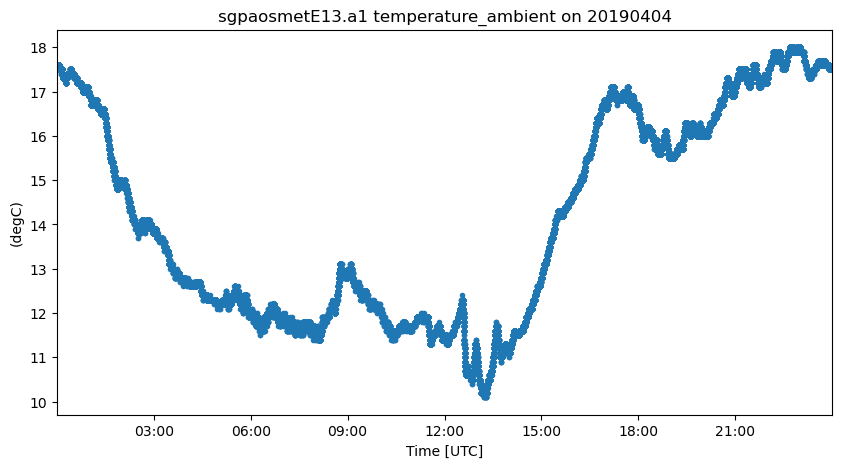

In [10]:
# Let's take a look at the quality control information associated with a variable from the MPL
variable = 'temperature_ambient'

# First, for many of the ACT QC features, we need to get the dataset more to CF standard and that
# involves cleaning up some of the attributes and ways that ARM has historically handled QC
ds_mpl.clean.cleanup()

# Apply corrections for the ceilometer, correcting for the vertical height
#ds_mpl = act.corrections.ceil.correct_ceil(ds_mpl,-999.0)

# Next, let's take a look at visualizing the quality control information
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(ds_mpl, figsize=(10, 5), subplot_shape=(1,))

# # Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,))

# # Plot up the QC variable in the second plot
# #display.qc_flag_block_plot(variable, subplot_index=(1,))
# plt.show()